In [2]:
from fastcore.xtras import load_pickle
import pandas as pd 
import os 
from glob import glob
from pathlib import Path
from scipy.stats import sem
import matplotlib.pyplot as plt
from datetime import datetime

import sys
sys.path.append("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/")
from plotutils import *

plt.style.use("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/kevin.mplstyle")

FOLDER = 'out'

In [3]:
if not os.path.exists(FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(FOLDER))

all_res = glob(f'{FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(FOLDER, len(all_res)))

Pickles found in out: 19


In [4]:

compiled_res_list = []
conf_mats = []

for results in all_res:
    res_full = load_pickle(results)
    res = res_full['results']
    if res_full['config']['tune_settings']['num_train_epochs'] != 20:
        continue
    summary = {
        'size': res_full['train_size'],
        #'representation': res_full['data_summary']['representation'],
        'target': res_full['data_summary']['target'],
        'accuracy': res['accuracy'],
        'f1_macro': res['f1_macro'],
        'f1_micro': res['f1_micro'],
        'kappa': res['kappa'],
        'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
        'lr': res_full['config']['tune_settings']['learning_rate'],
        'bins': len(set(res['all_y_true'])),
        'test_size': len(res['all_y_true'])
       
    }
    confusion_matrix = {
        'all_y_true':res['all_y_true'],
        'all_y_pred':res['all_y_pred']
    }
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)
print(compiled_res_list)

[{'size': 100, 'target': 'deltaG4_realbin-27_-39', 'accuracy': 0.8, 'f1_macro': 0.7916666666666667, 'f1_micro': 0.8, 'kappa': 0.6000000000000001, 'num_epochs': 20, 'lr': 0.0003, 'bins': 2, 'test_size': 10}, {'size': 100, 'target': 'deltaG4_realbin-27_-39', 'accuracy': 0.8, 'f1_macro': 0.8, 'f1_micro': 0.8, 'kappa': 0.6000000000000001, 'num_epochs': 20, 'lr': 0.0003, 'bins': 2, 'test_size': 10}, {'size': 100, 'target': 'deltaG4_realbin-27_-39', 'accuracy': 0.7, 'f1_macro': 0.6703296703296704, 'f1_micro': 0.7, 'kappa': 0.3999999999999999, 'num_epochs': 20, 'lr': 0.0003, 'bins': 2, 'test_size': 10}, {'size': 100, 'target': 'deltaG4_realbin-27_-39', 'accuracy': 0.9, 'f1_macro': 0.898989898989899, 'f1_micro': 0.9, 'kappa': 0.8, 'num_epochs': 20, 'lr': 0.0003, 'bins': 2, 'test_size': 10}, {'size': 100, 'target': 'deltaG4_realbin-27_-39', 'accuracy': 0.8, 'f1_macro': 0.8, 'f1_micro': 0.8, 'kappa': 0.6000000000000001, 'num_epochs': 20, 'lr': 0.0003, 'bins': 2, 'test_size': 10}, {'size': 100, '

In [5]:
compiled_res = pd.DataFrame(compiled_res_list)
grouped_res =compiled_res.groupby(['bins', 'num_epochs', 'target', 'size']).agg(['mean', 'sem'])


In [6]:
compiled_res

,size,target,accuracy,f1_macro,f1_micro,kappa,num_epochs,lr,bins,test_size
0,100,deltaG4_realbin-27_-39,0.8,0.791667,0.8,0.6,20,0.0003,2,10
1,100,deltaG4_realbin-27_-39,0.8,0.800000,0.8,0.6,20,0.0003,2,10
2,100,deltaG4_realbin-27_-39,0.7,0.670330,0.7,0.4,20,0.0003,2,10
3,100,deltaG4_realbin-27_-39,0.9,0.898990,0.9,0.8,20,0.0003,2,10
4,100,deltaG4_realbin-27_-39,0.8,0.800000,0.8,0.6,20,0.0003,2,10
5,100,deltaG4_realbin-27_-39,0.8,0.791667,0.8,0.6,20,0.0003,2,10
6,100,deltaG4_realbin-27_-39,0.9,0.898990,0.9,0.8,20,0.0003,2,10
7,100,deltaG4_realbin-27_-39,0.6,0.523810,0.6,0.2,20,0.0003,2,10
8,100,deltaG4_realbin-27_-39,1.0,1.000000,1.0,1.0,20,0.0003,2,10
9,100,deltaG4_realbin-27_-39,0.6,0.523810,0.6,0.2,20,0.0003,2,10


In [7]:
grouped_res


accuracy            f1_macro  \
                                                mean       sem      mean   
bins num_epochs target                 size                                
2    20         deltaG4_realbin-27_-39 100      0.79  0.040689  0.769926   

                                                      f1_micro            \
                                                  sem     mean       sem   
bins num_epochs target                 size                                
2    20         deltaG4_realbin-27_-39 100   0.049449     0.79  0.040689   

                                            kappa                lr       \
                                             mean       sem    mean  sem   
bins num_epochs target                 size                                
2    20         deltaG4_realbin-27_-39 100   0.58  0.081377  0.0003  0.0   

                                            test_size       
                                                 mean  sem  
bins num_epochs target                 size                 
2    20         deltaG4_realbin-27_-39 100       10.0  0.0

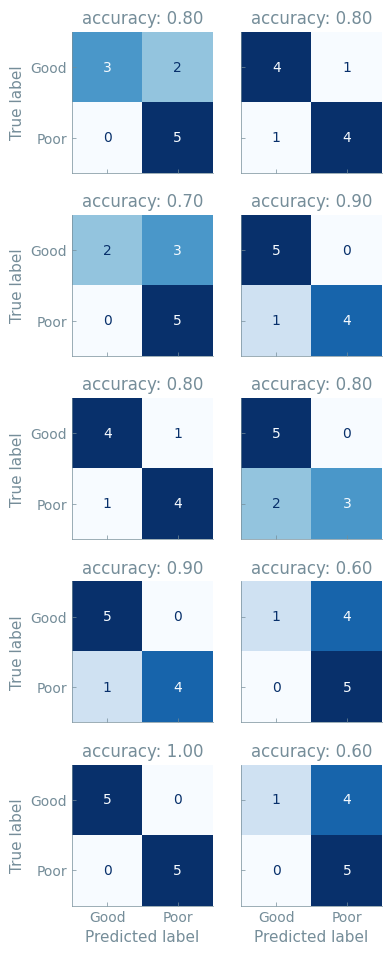

In [8]:
from sklearn.metrics import classification_report
from sklearn import metrics

fig, axes = plt.subplots(5,2, figsize = (4,11.5), sharey=True, sharex=True)
axes = axes.flatten()

for index, _ in enumerate(conf_mats):
    try:
        preds = conf_mats[index]
        actual	= preds['all_y_true']
        predicted	= preds['all_y_pred']

        gpt_metrics = compiled_res.iloc[index]
        confusion_matrix = metrics.confusion_matrix(actual, predicted)

        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Good','Poor'])
        cm_display.plot(cmap=plt.cm.Blues, ax=axes[index])

        axes[index].set_title(f"accuracy: {gpt_metrics['accuracy']:.2f}")
        
        im = axes[index].images
        cb = im[-1].colorbar
        cb.remove()



        if (index+1) < 9:
            axes[index].set_xlabel('')

        if (index+1) % 2 ==0:
            axes[index].set_ylabel('')

        if not os.path.exists('ConfusionMatrices'):
            os.mkdir('ConfusionMatrices')
        plt.savefig('ConfusionMatrices/{}_{}_size{}_epochs_{}_lr_{}.png'.format(FOLDER , gpt_metrics['target'], gpt_metrics['size'], gpt_metrics['num_epochs'], gpt_metrics['lr']))
    except Exception as e:
        print(e)
plt.show()

[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]


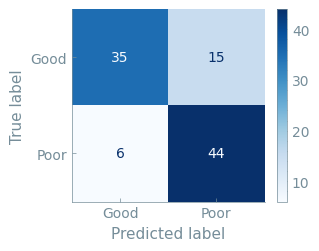

In [9]:
from sklearn.metrics import classification_report
from sklearn import metrics


actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats):
        preds = conf_mats[index]
        actual	= preds['all_y_true']
        predicted	= preds['all_y_pred']

        for i,j in zip(actual, predicted):
            actual_all.append(i)
            predicted_all.append(j)


print(actual_all)
confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Good','Poor'])
cm_display.plot(cmap=plt.cm.Blues)

plt.savefig('NiCatalyis_real.pdf', bbox_inches='tight')

[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]


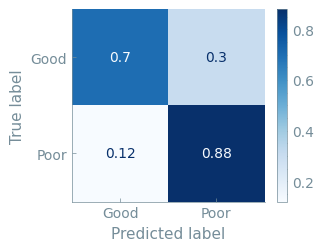

In [11]:
from sklearn.metrics import classification_report
from sklearn import metrics
import numpy as np

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats):
        preds = conf_mats[index]
        actual	= preds['all_y_true']
        predicted	= preds['all_y_pred']

        for i,j in zip(actual, predicted):
            actual_all.append(i)
            predicted_all.append(j)


print(actual_all)
confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_normalized, display_labels = ['Good','Poor'])
cm_display.plot(cmap=plt.cm.Blues)

plt.savefig('NiCatalyis_real_normalized.pdf', bbox_inches='tight')